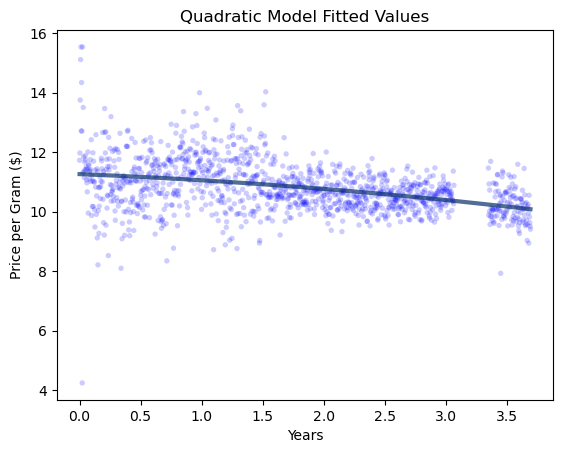

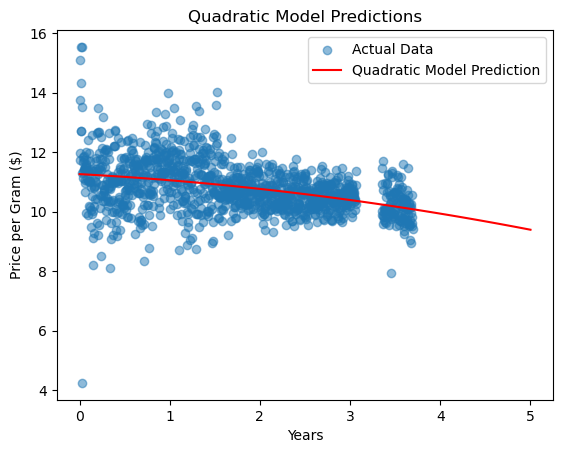

In [64]:
# Exercise 12-1

# 1. Import Libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import thinkplot
import thinkstats2

# 2. Data Loading and Preprocessing
def ReadData():
    transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
    return transactions

def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and computes the daily mean price per gram (ppg)."""
    groups = transactions[['date', 'ppg']].groupby('date')
    daily = groups.aggregate('mean')

    daily['date'] = daily.index
    start = daily.date.iloc[0]  # Use iloc to get the first element instead of direct indexing
    days_in_year = 365.25  # Approximate number of days in a year
    daily['years'] = (daily.date - start).dt.total_seconds() / (60 * 60 * 24 * days_in_year)
    return daily


transactions = ReadData()
daily_data = GroupByDay(transactions)

# 3. Modifying the Regression Model to Include a Quadratic Term
def RunQuadraticModel(daily):
    model = smf.ols('ppg ~ years + I(years**2)', data=daily)
    results = model.fit()
    return model, results

# 4. Plotting the Fitted Values
def PlotFittedValuesQuadratic(model, results, label=''):
    years = model.exog[:, 1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='quadratic model')

# 5. Generating Predictions
def GenerateQuadraticPrediction(results, years):
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    predict = results.predict(predict_df)
    return predict

# 6. Running the Full Analysis
daily = daily_data
model, results = RunQuadraticModel(daily)

# Plot fitted values
PlotFittedValuesQuadratic(model, results, label="Daily Prices")
plt.title('Quadratic Model Fitted Values')
plt.xlabel('Years')
plt.ylabel('Price per Gram ($)')
plt.show()

# Generate and plot predictions
years = np.linspace(0, 5, 101)
predictions = GenerateQuadraticPrediction(results, years)
plt.scatter(daily['years'], daily['ppg'], label="Actual Data", alpha=0.5)
plt.plot(years, predictions, label="Quadratic Model Prediction", color='red')
plt.title('Quadratic Model Predictions')
plt.xlabel('Years')
plt.ylabel('Price per Gram ($)')
plt.legend()
plt.show()


In [66]:
# Exercise 12-2

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import thinkstats2

# Define SerialCorrelationTest 
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    """Tests serial correlations by permutation."""

    def __init__(self, data, lag=1):
        """Initialize with the data and lag."""
        self.data = data
        self.lag = lag
        self.actual = self.TestStatistic(data)  # Compute the actual correlation

    def TestStatistic(self, data):
        """Computes the test statistic."""
        series, lag = data
        test_stat = abs(thinkstats2.SerialCorr(series, lag))  # Serial correlation
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis (permutation)."""
        series, lag = self.data
        # Randomly permute the data series to create a new model under the null hypothesis
        permutation = series.reindex(np.random.permutation(series.index))  
        return permutation, lag

    def PValue(self, iters=1000):
        """Computes the p-value by comparing the observed serial correlation to simulated correlations."""
        test_stats = [self.TestStatistic(self.RunModel()) for _ in range(iters)]
        # Count how many simulated correlations are greater than or equal to the actual correlation
        count = sum(1 for x in test_stats if x >= self.actual)
        return count / iters  # Return proportion of test stats greater than or equal to actual

# Define the function to run the quadratic model
def RunQuadraticModel(daily):
    """Runs a quadratic model of prices versus years."""
    daily["years2"] = daily.years**2  # Add quadratic term (years^2)
    model = smf.ols("ppg ~ years + years2", data=daily)  # Fit model with years and years^2
    results = model.fit()
    return model, results

# Define the function to run the linear model
def RunLinearModel(daily):
    """Runs a linear regression model of prices versus years."""
    model = smf.ols("ppg ~ years", data=daily)
    results = model.fit()
    return model, results

# Test serial correlation in raw price data and residuals from linear and quadratic models
def test_serial_correlation(daily, name):
    # Raw price data serial correlation
    series = daily.ppg
    test = SerialCorrelationTest((series, 1))  # Test with lag = 1 (consecutive days)
    pvalue_raw = test.PValue()
    print(f"{name} - Raw Price Data - Test Statistic: {test.actual}, p-value: {pvalue_raw}")

    # Linear model residuals
    _, linear_results = RunLinearModel(daily)
    series = linear_results.resid  # Residuals from linear model
    test_linear = SerialCorrelationTest((series, 1))
    pvalue_linear_residuals = test_linear.PValue()
    print(f"{name} - Linear Model Residuals - Test Statistic: {test_linear.actual}, p-value: {pvalue_linear_residuals}")

    # Quadratic model residuals
    _, quadratic_results = RunQuadraticModel(daily)
    series = quadratic_results.resid  # Residuals from quadratic model
    test_quadratic = SerialCorrelationTest((series, 1))
    pvalue_quadratic_residuals = test_quadratic.PValue()
    print(f"{name} - Quadratic Model Residuals - Test Statistic: {test_quadratic.actual}, p-value: {pvalue_quadratic_residuals}")

# Example usage for the 'high' quality category (or whichever dataset you have)
name = "high"  # You can change this to any identifier for your dataset
daily = daily  # Use the daily DataFrame for testing

# Test serial correlation for raw price data and residuals
test_serial_correlation(daily, name)



high - Raw Price Data - Test Statistic: 0.2312996241786398, p-value: 0.0
high - Linear Model Residuals - Test Statistic: 0.10627206063189254, p-value: 0.0
high - Quadratic Model Residuals - Test Statistic: 0.10372401040934821, p-value: 0.001
